# Self Declaration:  Hi, My name is Hitesh Sangwan and this code mentioned here is a part of my project on Style Transfer and its application during my nanodegree program at Udacity. Some part of this assignment is taken from that project. I have added all the required comments so that the implementation is easily understandable.

In [0]:
from PIL import Image
#To add image procession capability to our python Interpreter. Good for many file formats
from io import BytesIO
#To handle Input/Output using python. Useful Text, Binary data(BytesID is used for binary data)
import matplotlib.pyplot as plt
#To make data plots easily and effectively. Here we will also use it for picture represenatition.
import numpy as np
#numerical python is used for to give extensive matematical capabilities to our python interpreter.
import torch
#In this module I am using PyTorch because it is easy to use, open source and relatively powerful deep learning library and hence it has active support from community and researchers.
import torch.optim as optim
#It is used to handle optimization algorithms. 
import requests
#It is helpful in making HTTP requests using python. In this assignment it is used to import 
from torchvision import transforms, models
#It is a commonly used library which handles most popular model architectures, datasets and also the images proccessing capabilities which is why we are using it here in this project.

In [0]:
#Loading a pretrained VGG19 model and here we need only the feature layers not the classification ones.
#It consists of various deep learning layers which are alternate of Covolution, Max-Pool and RELU acivation function... 
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
  param.requires_grad_(False)
#We will freeeze all VGG parameters as we are only optimizing the target image. So we only need the features portion and the weights are freezed.

In [6]:
#Looking for GPU. If GPU is available, then the model will train on GPU else on CPU. The models run on GPU are faster depending exclusively on the 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
def load_image(img_path, max_size=400, shape=None):
#defining a new function to load and define the Image properties...example size and shape......
#Load in and transformation of an Image making sure the size does not exceed 400pixels....
    #Here the request library comes into effect...if there is a http in the img path it will help us to retrieve the image from the web.
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    #We will covent the image into normalized tensors.... 
    # large images will slow down processing and hence smaller images are easier to train and the style can be easily picked up as there will be a sudden change in pixel colors a clear indication of change....
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [0]:
# load in content and style image
content = load_image('/japanese_garden.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('/picasso_selfportrait.jpg', shape=content.shape[-2:]).to(device)

In [0]:
# im_convert function to un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

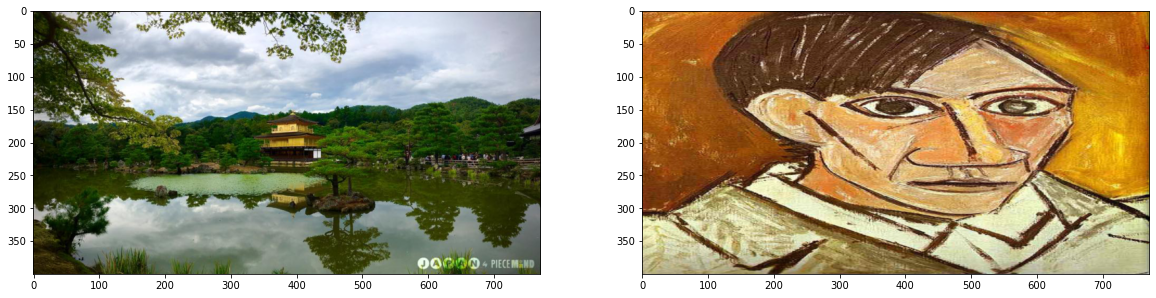

In [11]:
# display the images using matplotlib(Just for reference)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [12]:
# print out VGG19 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
def get_features(image, model, layers=None):
    # Run an image forward through a model and get the features for 
    # a set of layers. Default layers are for VGGNet matching Gatys et al paper(2016)
    
    
    ## Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [0]:
def gram_matrix(tensor):
    #Calculate the Gram Matrix of a given tensor 
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel (Flatten the layer)
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix using torchh library
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [0]:
# get content and style features only once before training
#1. Get features of the content image using this function call
content_features = get_features(content, vgg)
#2. Get style of the style image using this function call
style_features = get_features(style, vgg)
# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# The new target image can be actauall a base case of the content image and for the new image  
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [0]:
#Tuning the Hyperparameters......
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # defining alpha
style_weight = 1e6  # defining beta

Total loss:  29298598.0


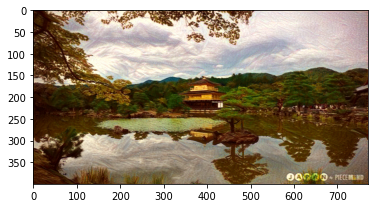

Total loss:  11897067.0


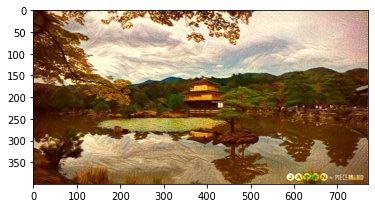

Total loss:  5381449.5


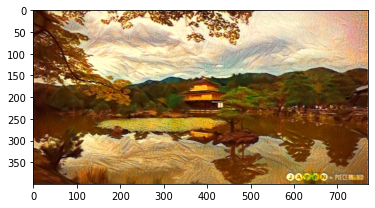

Total loss:  2507132.75


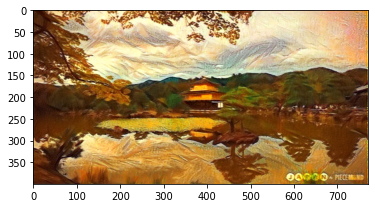

Total loss:  1256700.5


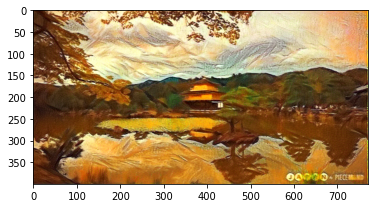

In [17]:
# for displaying the target image, intermittently so that you can view the progress
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image...

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

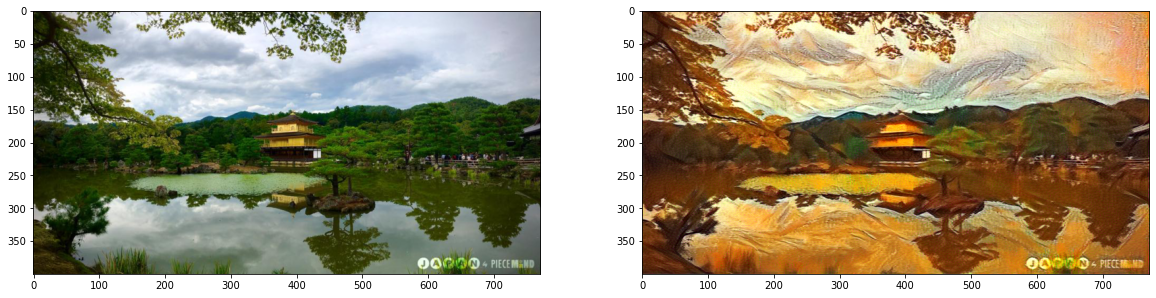

In [0]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))